# Overview

This document covers the transformation of ICESat-2 photon data over a target reef to depth estimates that will be used to calibrate Sentinel-2 bathymetry estimates.  The relevant program files are located in the <i><b>/src</i></b> directory in Karan Sunil's "Coral-Reef-Bathymetry" distribution on GitHub: https://github.com/karans04/Coral-Reef-Bathymetry

## 1.) Import packages

To begin, make sure this notebook is located and launched from a working directory containing <i><b>Depth_profile.py</i></b> and the other python files in Karan's distribution. After the imports below, any function available in <i><b>Depth_profile.py</i></b> can be called from this notebook with the syntax: depth.function_name(parameters). The same goes for the other imported python files.

Note: sentinelsat is a package external to Anaconda3.  Downloaded the package from ESA, unzip, cd into it, then install into the base environment using /opt/anaconda3/bin/pip3 install sentinelsat or into a virtual environment using /opt/anaconda3/envs/[env name]/bin/pip3 install sentinelsat.

Also, to get Beautiful Soup to work, I had to install the lxml library from the command line: conda install --name rasteriok lxml

In [23]:
import geopandas as gpd
import h5py
import importlib
import json
import lxml
import math
import matplotlib
import numpy as np
import os
import pandas as pd
import pyproj as proj
import rasterio
import requests
import seaborn as sns
import sys
import zipfile
import fiona

from bs4 import BeautifulSoup
from datetime import datetime
from pathlib import Path
from scipy.stats import pearsonr
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from tqdm import tqdm

import ATL03_API as is2api
import Coral_Reef as coral_reef
import Depth_profile as depth
import ICESAT_plots as is2_plot
import IS2_file as is2File
import Pixel_transformation as pt
import Reef_plots as reef_plots
import Sentinel_API as sentinel
import Sentinel2_image as s2_img
import Tide_API as tide
import Water_level as water_level

from pyproj import CRS
from pyproj import Transformer
import matplotlib.pyplot as plt

## 2.) Create directories and external files needed for depth processing

In working directory, create a folder called <i><b>data</i></b> and create subfolders for each reef being analyzed.  Within each subfolder, provide the following folders/files:

<blockquote><b>A.)</b> a GeoJSON file containing the outline of the reef, named <i><b>reef_name.geojson</i></b>.  This file is obtained from http://geojson.io/#map=2/20.0/0.0.  Switch to "OSM model" in bottom left corner of window, mark the boundary of reef with the cursor, save points using the menu at upper left (save->GeoJSON), then rename map.geojson file and move to data directory.
<p>
<b>B.)</b> a folder named <i><b>H5</i></b> which contains ICESat-2 ATL03 data files for this reef.  These are HDF5 files that can be obtained from OpenAltimetry (http://www.openaltimetry.org) or from NASA EarthData search (https://search.earthdata.nasa.gov/search/granules?p=C1705401930-NSIDC_ECS)
<p>
<b>C.)</b> a file called <i><b>reef_name.text</i></b> containing metadata.  The format must be:<br>
<blockquote>Coordinates: <p>
[min_lat, max_lat, min_lon, max_lon] <br><br>H5 Files:<br>List of all h5 files in folder H5, one file per line.</blockquote></blockquote>

## 3.) Input metadata for reef processing

[run.py] <br>
Setting reef processing parameters can be done programatically via Karan's top-level processing script <i><b>run.py</i></b>, which updates <i><b>config/data-params.json</i></b>. Here these parameters are set via the command line.

In [24]:
#General Metadata
data_dir = '/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/'
start_date = '20171201'
end_date = '20201201'
redownload_is2 = False  #False = use the data already downloaded into the directory
earthdata_username = 'aborsa'
earthdata_password = ''
sentinel_username = 'aborsa_sentinel'
sentinel_password = 'Esa0169!'
world_tide_API_key = 'fee8ff39-48eb-42a7-bcc5-3819fce3c1e4'

#Reef Metadata
reef_name = 'nasau'

## 4.) Initialize Coral_Reef( ) data object

[run.py] <br>
Create a Coral_Reef object to hold metadata for each reef. Take a look in Coral_Reef.py for the methods and variables defined for the Coral_Reef class. Also note that the get_bounding_box( ) method queries <i><b>/data/reef_name/reef_name.txt</i></b> to grab the reef bounding box coordinates.

In [25]:
importlib.reload(coral_reef)

reef = coral_reef.Coral_Reef(data_dir, reef_name)
icesat_fp, proc_fp, images_fp, data_plots_path = reef.get_file_drectories()
print(icesat_fp, proc_fp, images_fp, data_plots_path)

/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/Output/Data_Cleaning/ICESAT_photons /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/Output/Data_Cleaning/Processed_output /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/Output/Data_Cleaning/Imgs /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/Output/Data_Cleaning/Data_plots


## 5.) Get ICESat-2 data for reef

[run.py] <br>
This requires running <i><b>/src/IS2_file.main()</i></b>, which we are not going to do for this example. ICESat-2 HDF5 files will be downloaded into <i><b>H5</i></b> folder, and optionally those with litte/bad data will be culled and put into <i><b>H5_bad</i></b> folder.

## 6a.) Read photon data and calculate photon depths relative to observed sea level

[run.py / Depth_profile.py / get_depths(reef) / process_H5()]<br>
Assuming for now that the ICESat-2 data have been downloaded and dropped into the <i><b>H5</i></b> directory.
The depth.process_H5(reef) method will run the entire depth estimation workflow. Here it is line-by-line:

In [26]:
# x-y rotation function used to convert to along-track coordinate frame
def xyRotate(x,y,theta,**kwargs):
    """
    xyRotate  Rotate data.
    clockwise rotation around origin XO,YO
    [XR YR] = xyRotate(X,Y,THETA) rotates the coordinates X,Y by THETA
    (theta in radians). (Origin does not move, X0 = 0, Y0 = 0)
    OR
    [XR YR] = xyRotate(X,Y,THETA,xo=XO,yo=YO) rotates the coordinates around the
    origin XO,YO.
    Note: Clunky as this is modified from one of my Matlab functions. Find more 'pythonic' way?
    """
    # Default origin is 0,0
    xo = kwargs.get("xo",0)
    yo = kwargs.get("yo",0)
    # Ravel and Translate
    xt = np.ravel(x)-xo
    yt = np.ravel(y)-yo
    # Create xy Matrix of raveled translated data
    xt = xt.reshape(len(xt),1)
    yt = yt.reshape(len(yt),1)
    XYt = np.hstack((xt,yt))
    # Rotation Matrix
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta),  np.cos(theta)]])
    # Rotate
    XYr = np.matmul(XYt,R)
    xrlong = XYr[:,0]
    yrlong = XYr[:,1]
    xr = xrlong.reshape(x.shape)
    yr = yrlong.reshape(y.shape)
    return xr, yr


processed_ATL03_20181210123712_11130108_003_01.h5

Reading photons from prior csv file for gt1r
Number photons in gt1r is 32705
12996
Number depth photons in gt1r is 12996

Reading photons from prior csv file for gt2r
Number photons in gt2r is 20330
5010
Number depth photons in gt2r is 5010

Reading photons from prior csv file for gt3r
Number photons in gt3r is 8856
1738
Number depth photons in gt3r is 1738

processed_ATL03_20190311081711_11130208_003_01.h5

Reading photons from prior csv file for gt1l
Number photons in gt1l is 1177
191
Number depth photons in gt1l is 191

Reading photons from prior csv file for gt2l
Number photons in gt2l is 3271
873
Number depth photons in gt2l is 873

Reading photons from prior csv file for gt3l
Number photons in gt3l is 5286
903
Number depth photons in gt3l is 903

processed_ATL03_20190610035647_11130308_003_01.h5

Reading photons from prior csv file for gt1l
Number photons in gt1l is 14858
5699
Number depth photons in gt1l is 5699

Reading photon

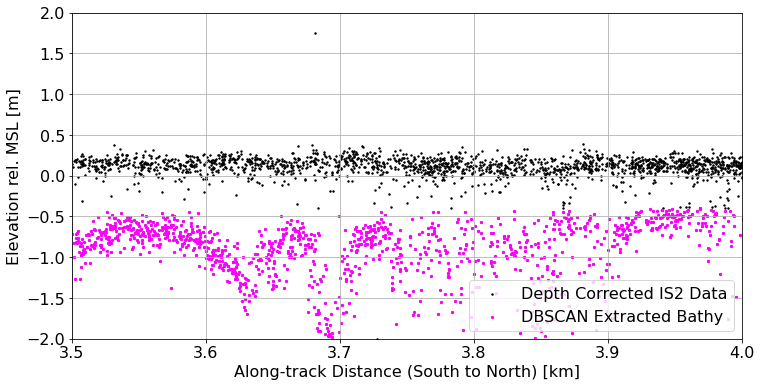

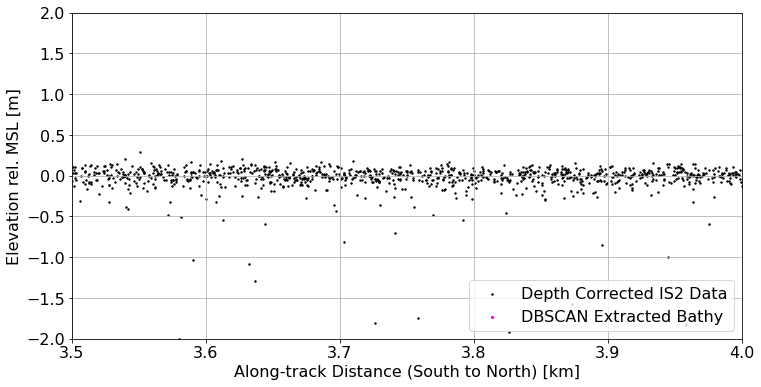

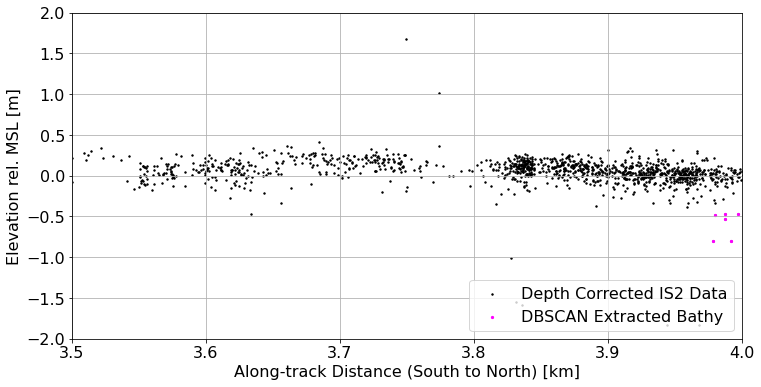

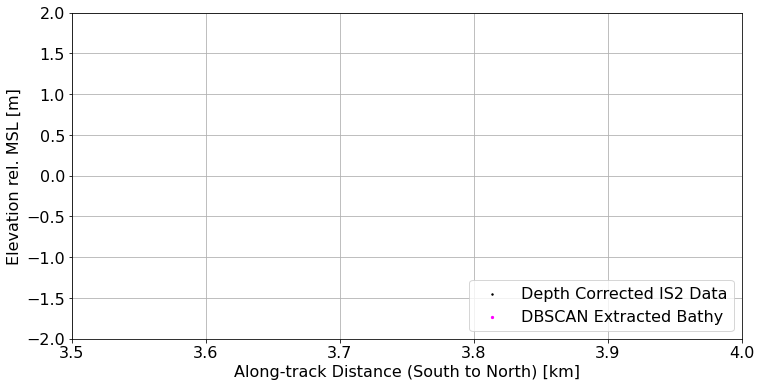

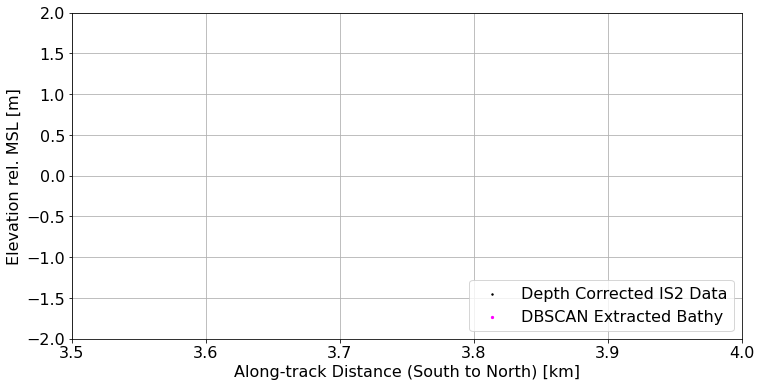

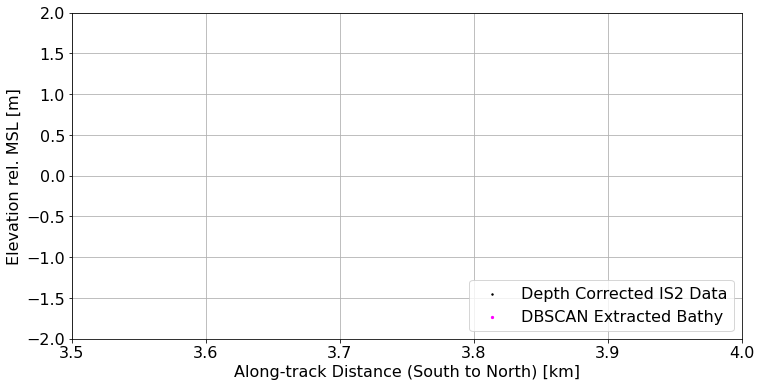

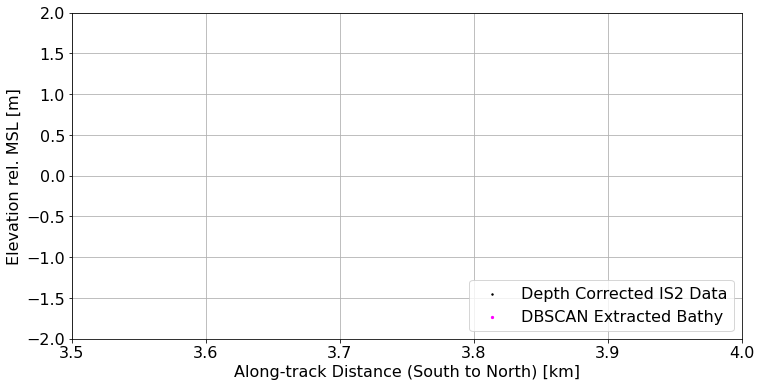

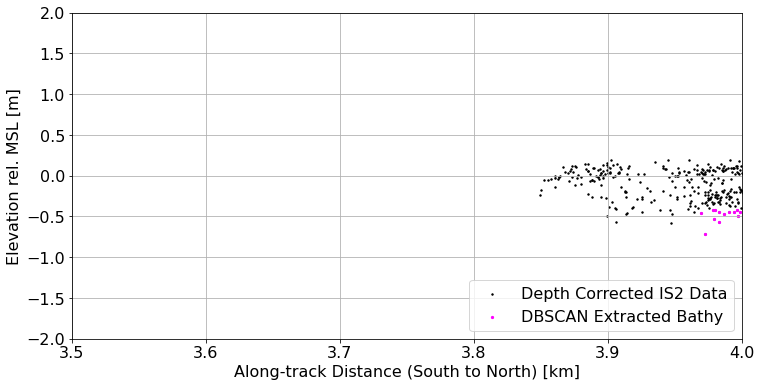

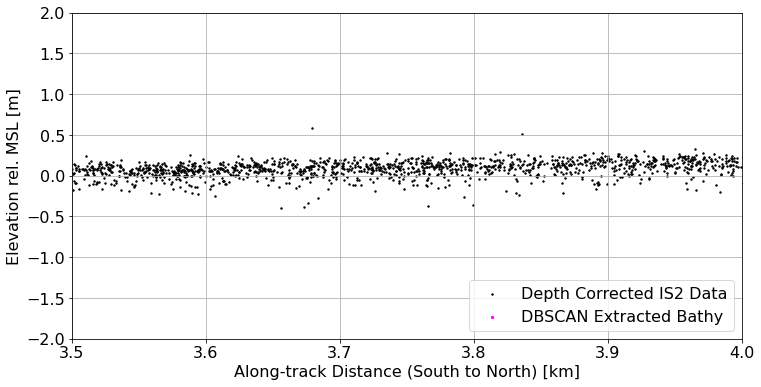

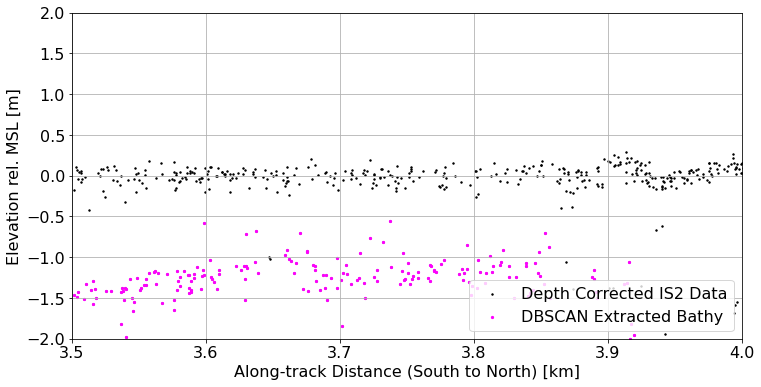

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [51]:
#Get IS2 file directory and filenames
h5_dir = os.path.join(reef.get_path(),'H5')
h5_filenames = [f for f in os.listdir(h5_dir) if not f.startswith('.')]
h5_filenames.sort()

importlib.reload(depth)
importlib.reload(is2File)
importlib.reload(is2_plot)
importlib.reload(water_level)

# setup coordinate projections
crs_wgs = CRS(4326) # WGS84 geographic
crs_bng = CRS(3857) # CRS with units of meters


for h5_fn in h5_filenames:
    print('\n' + h5_fn)

    #Inititalize ICESat-2 file object
    is2 = is2File.IS2_file(h5_dir, h5_fn, reef.bbox_coords)
    is2_file_tag = is2.get_file_tag()
    strong_beams = is2.get_strong_lasers()

    for laser in strong_beams:
        plt.figure(figsize=(12,6))
        
        #Output directory for csv file containing raw photon data
        photon_fn = '{reef_name}_photons_{h5_fn}_{laser}.csv'.format(reef_name=reef_name, h5_fn=is2_file_tag, laser=laser)
        photons_path = os.path.join(icesat_fp, photon_fn)
    
        #Load raw photon data from .CSV if it already exists, else extract data from subsetted IS2 H5 file
        if not os.path.exists(photons_path):

            #From process_h5(): df = convert_h5_to_csv(is2_file, laser, photons_path)
        
            #Create dataframe with photon data from subsetted IS2 H5 file
            photon_data = is2.get_photon_data(laser)  
            if len(photon_data) == 0:
                print('No photons in file for {}'.format(laser))
                continue            
            df_laser = depth.create_photon_df(photon_data)

            #Clip dataframe to reef bounding shape
            reef_polygon = reef.return_reef_polygon()
            gdf = gpd.GeoDataFrame(df_laser, geometry=gpd.points_from_xy(df_laser.Longitude, df_laser.Latitude))
            poly_gdf = gpd.GeoDataFrame([1], geometry=[reef_polygon])
            gdf_clipped = gpd.clip(gdf, poly_gdf)
            df = pd.DataFrame(gdf_clipped)
            
            #Clip dataframe to locations within the reef bounding box
            #coords = is2.get_bbox_coordinates()
            #min_longitude,min_latitude,max_longitude,max_latitude = coords
            #df = df_laser.loc[(df_laser.Longitude > min_longitude) & (df_laser.Longitude < max_longitude) &\
            #(df_laser.Latitude > min_latitude) & (df_laser.Latitude < max_latitude)]
            
            #If there are photons in the new clipped dataframe
            if len(df) != 0:    
            
                #Unpack the confidence array to individual columns is now done in get_photon_data above
                    #df = depth.individual_confidence(df)
                #DBSCAN now done later, after adjusting for water depth
                    #surface_photons = depth.apply_DBSCAN(df, processed_output_path,is2, laser, eps_val, min_samp)

                #Adjust elevations to reference local sea level (currently this step ALSO subsets on confidence==4)
                #Unlike Karan's code, df now contains 'sea_level', which is what has been removed from 'Heights'
                df,f = water_level.normalise_sea_level(df)
                #is2_plot.plot_is2_depths(df, is2, laser, f, [0, 55], 'Raw Photon Elevs')
                if len(df) == 0:  
                    print('Failed at sea level parameterization for {}'.format(laser))
                    continue
                is2.set_sea_level_function(f,laser)

                #Adjust depth for speed of light in water
                df = water_level.adjust_for_speed_of_light_in_water(df)
                #is2_plot.plot_is2_depths(df, is2, laser, 'False', [-25, 5], 'Adjusted Photon Elevs')

                #Write a dataframe containing just the photon data in bounding box that meet the confidence criterion
                #print('Writing photons for clipped dataframe to csv file for {}'.format(laser))
                df.to_csv(photons_path)
            else:
                print('No photons over reef for {}'.format(laser))
            
        else:
            print('\n' + 'Reading photons from prior csv file for {}'.format(laser))
            df = pd.read_csv(photons_path)
            is2.metadata = is2.load_json()
        
        
        print('Number photons in {laser} is {reef_length}'.format(laser=laser, reef_length=str(len(df))))
           
        #Classify seafloor photons
        eps_val = 0.75
        min_samp = 4
        bathy, non_bathy = depth.apply_DBSCAN(df, eps_val, min_samp, -50, -0.4)
        print(len(bathy))
            
        if len(bathy) == 0:
            print('No bathymetric photons found for {}'.format(laser))
            continue
        print('Number depth photons in {laser} is {reef_length}'.format(laser=laser, reef_length=str(len(bathy))))
  
        #Output just bathymetric photons to new .CSV file
        depths_fn = '{reef_name}_{h5_fn}_{laser}.csv'.format(reef_name=reef_name,h5_fn=is2_file_tag,laser=laser)
        processed_output_path = os.path.join(proc_fp,depths_fn)
        bathy.to_csv(processed_output_path)
        
        transformer = Transformer.from_crs(crs_wgs, crs_bng,always_xy=True)
        df.loc[:,'x'],df.loc[:,'y'] =  transformer.transform(df.Longitude.values, df.Latitude.values)
        bathy.loc[:,'x'],bathy.loc[:,'y'] =  transformer.transform(bathy.Longitude.values, bathy.Latitude.values)
        
        # fit a line to the data
        m, b = np.polyfit(df.x.values, df.y.values, 1)
        # calculate rotation and translation parameters from fit for new track-oriented coords 
        # rotation angle
        theta = -np.arctan(-(1/m))
        # offset such that southernmost point is zero
        y0 = min(df.y.values)
        x0 = (y0-b)/m
        # translate and rotate to along (alg) and cross (crs) track coordinates
        df.loc[:,'crs'], df.loc[:,'alg'] = xyRotate(df.x.values,df.y.values,theta,xo=x0,yo=y0)
        bathy.loc[:,'crs'], bathy.loc[:,'alg'] = xyRotate(bathy.x.values,bathy.y.values,theta,xo=x0,yo=y0)
        
        
        #print('df')
        #print(df)
        #print('bathy')
        #print(bathy)
        #Plot depths
        plt.scatter(df.alg/1000, df.Height, s = 2, color = 'black', label = 'Depth Corrected IS2 Data')
        plt.scatter(bathy.alg/1000, bathy.Height, s= 5, color = 'magenta',label = 'DBSCAN Extracted Bathy') 
        plt.ylim(-2, 2)
        plt.xlim(3.5, 4)
        #plt.xlim(0,9.5)
        #plt.title('More shallow depth (Exact depth unknown here)')
        plt.xlabel('Along-track Distance (South to North) [km]', fontsize=16)
        plt.ylabel('Elevation rel. MSL [m]', fontsize=16)
        ax = plt.gca()
        ax.tick_params(axis='both', which='major', labelsize=16)
        plt.grid(True)
        plt.legend(loc='lower right',fontsize=16)
        
#         is2_plot.plot_is2_depths_bathy(df, is2, laser, bathy, images_fp, 'False', [-25, 5], 'Corrected Bathymetric Profile')



## 7.) Get Sentinel-2 images

This uses code taken from Sentinel_API.py/get_sentinel_images(reef, start_date, end_date, num_images,user,password, cloud_cover_percentage)

In [10]:
#importlib.reload(sentinel)
cloud_cover_percentage = [0, 2]

#sentinel.get_sentinel_images(reef, start_date, end_date, 10, sentinel_username, sentinel_password, cloud_cover_percentage)
api = SentinelAPI(sentinel_username, sentinel_password, 'https://scihub.copernicus.eu/dhus')
reef_path = reef.get_path()
reef_gjson_fp = os.path.join(reef_path ,reef.get_reef_name()+'.geojson')
reef_footprint = geojson_to_wkt(read_geojson(reef_gjson_fp))
sentinel_path = os.path.join(reef_path, 'SAFE_files')

products = api.query(reef_footprint,date = (start_date, end_date),platformname = 'Sentinel-2',\
            area_relation = 'Intersects',processinglevel = 'Level-2A',\
            cloudcoverpercentage = cloud_cover_percentage, order_by = 'cloudcoverpercentage')  
print('Number of scenes: {}'.format(len(products)))

for i,x in enumerate(products.items()):
    k,v = x[0],x[1]
    safe_folder = os.path.join(sentinel_path, v['title'] + '.SAFE')
    if not os.path.exists(safe_folder):
        print('Downloading: {}'.format(safe_folder))
        api.download(k, directory_path = sentinel_path)
    else:
        print('{} exists!'.format(safe_folder))
        
#unzipping files
for file in os.listdir(sentinel_path):
    if file.endswith('.zip'):
        file_path = os.path.join(sentinel_path, file)
        out_path = os.path.join(sentinel_path, file.split('.')[0])

        if os.path.exists(file_path) and not os.path.exists(out_path):
            with zipfile.ZipFile(file_path,"r") as zip_ref:
                zip_ref.extractall(sentinel_path)
            os.remove(file_path)

Number of scenes: 6
Downloading: /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/SAFE_files/S2B_MSIL2A_20200510T220919_N0214_R129_T01KCV_20200510T235623.SAFE


Downloading: 100%|██████████| 776M/776M [09:07<00:00, 1.42MB/s] 
MD5 checksumming: 100%|██████████| 776M/776M [00:01<00:00, 477MB/s] 


Downloading: /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/SAFE_files/S2B_MSIL2A_20190605T220929_N0212_R129_T01KCV_20190606T000535.SAFE


Product abae5ee5-946e-4028-8711-ba8c97bde611 is not online. Triggering retrieval from long term archive.


/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/SAFE_files/S2A_MSIL2A_20190809T220921_N0213_R129_T01KCV_20190809T235948.SAFE exists!
Downloading: /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/SAFE_files/S2B_MSIL2A_20190715T220929_N0213_R129_T01KCV_20190716T001515.SAFE


Product 58b60422-8883-4715-8951-9dbe6af3367c is not online. Triggering retrieval from long term archive.


Downloading: /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/SAFE_files/S2B_MSIL2A_20200121T220909_N0213_R129_T01KCV_20200121T235759.SAFE


Downloading: 100%|██████████| 814M/814M [10:36<00:00, 1.28MB/s] 
MD5 checksumming: 100%|██████████| 814M/814M [00:02<00:00, 385MB/s] 


Downloading: /Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/nasau/SAFE_files/S2A_MSIL2A_20200813T220921_N0214_R129_T01KCV_20200814T001117.SAFE


Downloading: 100%|██████████| 546M/546M [21:45<00:00, 418kB/s]  
MD5 checksumming: 100%|██████████| 546M/546M [00:01<00:00, 366MB/s] 


## 8.) Process Sentinel-2 images

This uses code taken from Pixel_transformation.py/all_safe_files(reef).<br>
Band 02 = Blue, Band 03 = Green, Band 04 = Red, Band 08 = Infrared.  All are 10 m resolution.

S2A_MSIL2A_20191018T220921_N0213_R129_T01KCV_20191018T235259.SAFE


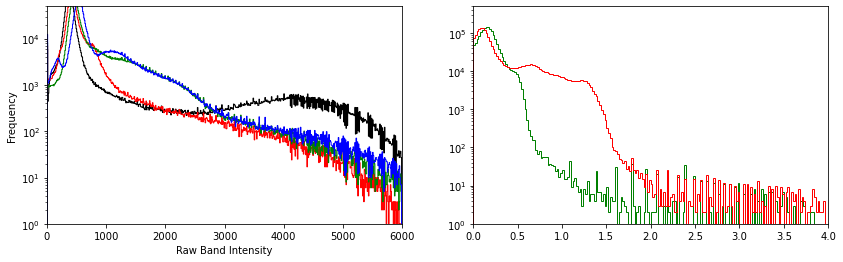

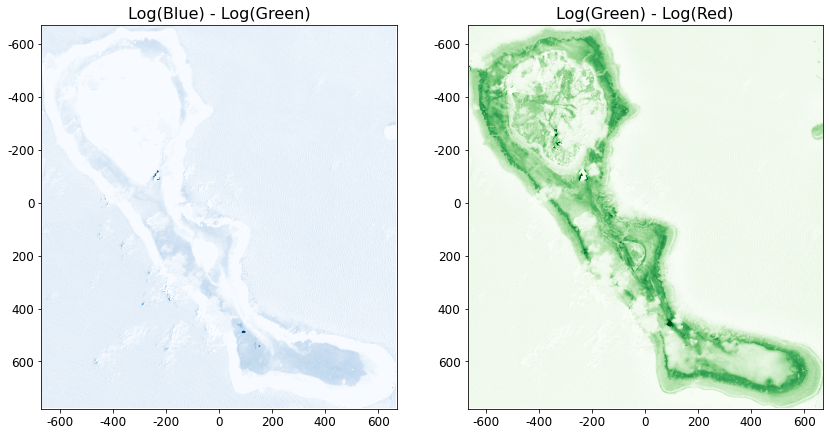

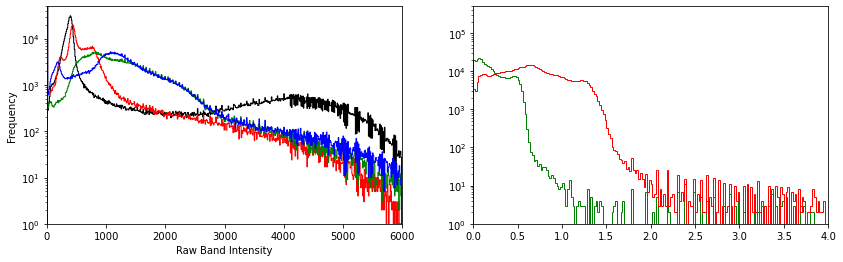

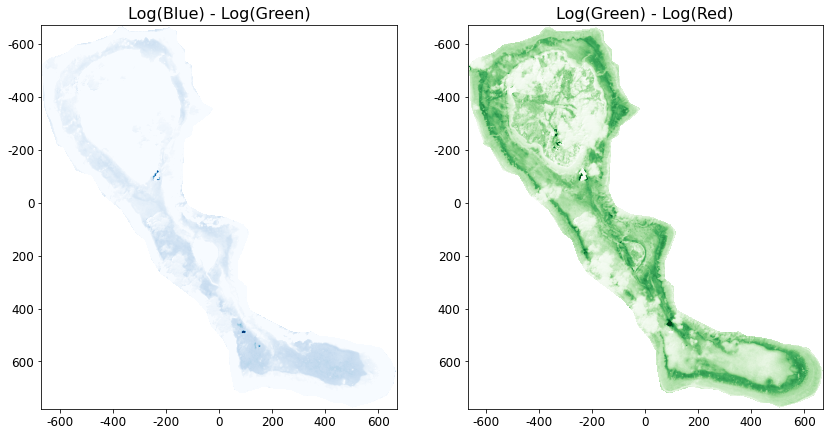

In [11]:
importlib.reload(s2_img)
importlib.reload(pt)
importlib.reload(tide)
importlib.reload(reef_plots)
from rasterio.plot import show_hist
import matplotlib.pyplot as plt

datum = {}
medians, variances = [], []
master_df = pd.DataFrame()

median_threshold, variance_threshold = 1, 1

reef_path = reef.get_path()
reef_name = reef.get_reef_name()
safe_files = os.path.join(reef_path, 'SAFE_files')
coords = reef.get_bounding_box()

#for sf in os.listdir(safe_files):
#    if sf.endswith('.SAFE'):
#        #creates object to represent sentinel image
#        sf_path = os.path.join(reef_path, sf)
#        safe_file = s2_img.Sentinel2_image(sf_path,coords)
#        #get out file directories
#        imgs_path, depth_preds_path, training_data_path = safe_file.get_file_directories()
#        #fits the regressor with training data
#        r,m,d = get_regressor(reef,safe_file)

sf = os.listdir(safe_files)
sf = [f for f in sf if f.endswith('.SAFE')]
sf.sort()
sf = sf[1]  #just work with first SAFE file for now
print(sf)

#creates object to represent sentinel image
sf_path = os.path.join(reef_path, sf)
safe_file = s2_img.Sentinel2_image(sf_path,coords)
#get file directories
imgs_path, depth_preds_path, training_data_path = safe_file.get_file_directories()

#load in the different band images required
#imgs = safe_file.load_sentinel()
meta = safe_file.get_meta()

imgs = safe_file.load_sentinel_full()
reef_plots.band_histogram_full(imgs, meta)

imgs = safe_file.load_sentinel()
reef_plots.band_histogram_full(imgs, meta)

In [12]:
blue = imgs[0].astype(float)
blue

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

This uses code taken from:<br> Pixel_transformation.py/get_regressor(reef, sf) <br> Pixel_transformation.py/load_ICESAT_predictions(icesat_proc_path,sf) 

In [13]:
#create a training dataset using ICESAT 2 depth profile
#train = pt.load_ICESAT_predictions(icesat_proc_path, safe_file)
icesat_proc_path = reef.get_processed_output_path()
train_raw = pd.DataFrame()
is2files = [file for file in os.listdir(icesat_proc_path) if file.endswith('.csv')]

for fn in is2files:
    train_path = os.path.join(icesat_proc_path, fn)
    #pt.pref_df gets tides and corrects IS2 training bathymetry to depth valid for Sentinel-2 imate date
    train_raw = pd.concat([train_raw, pt.prep_df(safe_file, train_path, safe_file.get_crs())])   

#drop any nan rows
train_raw = train_raw.dropna()
train_raw['x'] = train_raw.Coordinates.x
train_raw['y'] = train_raw.Coordinates.y
#photon_location = sns.scatterplot(x = train_raw['x'], y = train_raw['y'], color = 'black')  

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: 0.411



/Users/bonnieludka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: 0.411

2018-12-10 12:37:12
ICESat-2 tide level: -0.219
Sentinel-2 tide level: 0.411

2019-03-11 08:17:11
ICESat-2 tide level: 0.282
Sentinel-2 tide level: 0.411

2019-03-11 08:17:11
ICESat-2 tide level: 0.282
Sentinel-2 tide level: 0.411

2019-03-11 08:17:11
ICESat-2 tide level: 0.282
Sentinel-2 tide level: 0.411

2019-06-10 03:56:47
ICESat-2 tide level: -0.244
Sentinel-2 tide level: 0.411

2019-06-10 03:56:47
ICESat-2 tide level: -0.244
Sentinel-2 tide level: 0.411

2019-06-10 03:56:47
ICESat-2 tide level: -0.244
Sentinel-2 tide level: 0.411

2020-03-08 14:56:11
ICESat-2 tide level: 0.002
Sentinel-2 tide level: 0.411



This uses code taken from:
Pixel_transformation.py/get_regressor(reef, sf) 

In [14]:
def get_pixel_val(coord):
    """
    Get pixel value given a set of coordinates
    Params - 1. coord (Point) - point of interest
    Return int - pixel value at point
    """
    x_index = int((coord.x - meta['ulx']) // meta['xdim'])
    y_index = int((coord.y - meta['uly']) // (meta['ydim']))
    return [data[0][y_index][x_index] for data in imgs]

def get_pixel_image_coords(coord):
    """
    Get pixel value given a set of coordinates
    Params - 1. coord (Point) - point of interest
    Return int - pixel value at point
    """
    x_index = int((coord.x - meta['ulx']) // meta['xdim'])
    y_index = int((coord.y - meta['uly']) // (meta['ydim']))
    return y_index, x_index

def extract_pixel_cols(df):
    """
    Extracts band values for image
    Params - 1. df (DataFrame) - depth predictions of ICESAT-2
    Return - DataFrame - pixel values added for each point
    """
    df['Pixels'] = df.Coordinates.apply(get_pixel_val)
    df['b2'] = df.Pixels.apply(lambda x: (x[0]))
    df['b3'] = df.Pixels.apply(lambda x: (x[1]))
    df['b4'] = df.Pixels.apply(lambda x: (x[2]))
    df['b8'] = df.Pixels.apply(lambda x: (x[3]))
    
    #converts points with pixel values above the mask threshold to nan
    #df['mask'] = df.b8.apply(lambda x: False if x < mask_thresh else True)
    
    return df

0 6032 1450.0 1599.544327084721
0 5380 1556.0 1660.2577473276874
0 4196 701.0 816.3230247089796
0 3898 380.0 533.4279823643226 593.1403518789818
64.49221645663455


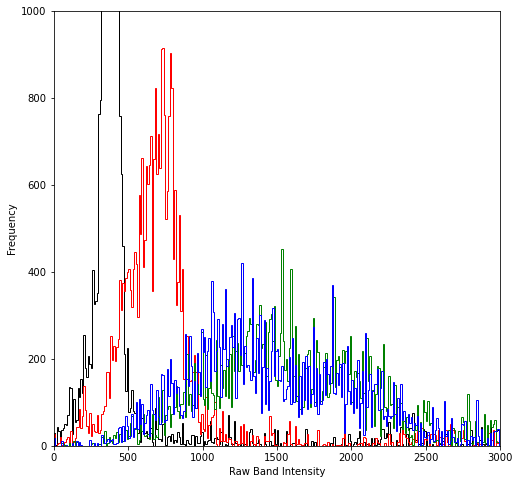

In [15]:
#fits the regressor with training data
#r,m,d = get_regressor(reef,safe_file)

### get band values at IS2 pixels
train = train_raw.copy(deep=True)  #first make a copy of "train_raw" so it can be altered for each S2 image
train = extract_pixel_cols(train)

print(min(train['b2']), max(train['b2']), np.median(train['b2']), np.mean(train['b2']))
print(min(train['b3']), max(train['b3']), np.median(train['b3']), np.mean(train['b3']))
print(min(train['b4']), max(train['b4']), np.median(train['b4']), np.mean(train['b4']))
print(min(train['b8']), max(train['b8']), np.median(train['b8']), np.mean(train['b8']), np.std(train['b8']))

b8_robust_sigma = np.subtract(*np.percentile(train['b8'], [75, 25]))/1.349
print(b8_robust_sigma)
importlib.reload(reef_plots)
reef_plots.band_histogram(train)

In [16]:
#creates the masking threshold for band 8 (infrared) to mask land and clouds
#mask_thresh = np.median(train['b8']) + (np.std(train['b8'])) #threshold is median val + 1 sigma
mask_thresh = np.median(train['b8']) + b8_robust_sigma #threshold is median val + 1 sigma
print(mask_thresh)
safe_file.meta['mask_thresh'] = mask_thresh
train['mask'] = train.b8.apply(lambda x: False if x < mask_thresh else True)

#remove cloud pixels and zeroed out pixels
train = train.loc[(train.b3 != 0) & (train.b2 != 0)]
train = train.loc[train['mask'] == False]

#plot sentinel image with IS2 locations overplotted
image_coords = train.Coordinates.apply(get_pixel_image_coords)
train['image_coords'] = train.Coordinates.apply(get_pixel_image_coords)

444.49221645663454


In [17]:
print(min(train['b2']), max(train['b2']), np.median(train['b2']), np.mean(train['b2']))
print(min(train['b3']), max(train['b3']), np.median(train['b3']), np.mean(train['b3']))
print(min(train['b4']), max(train['b4']), np.median(train['b4']), np.mean(train['b4']))
print(min(train['b8']), max(train['b8']), np.median(train['b8']), np.mean(train['b8']), np.std(train['b8']))

54 3088 1338.0 1437.72685094169
52 2930 1498.0 1535.3855620650336
4 1158 672.0 646.7726968898675
1 444 367.0 349.539260016514 73.07969489452762


In [18]:
importlib.reload(pt)

### calculates the log difference between band2 and band3 pixels
delta = 0.0001
bp = {'B02': 1, 'B03': 1, 'B04': 1}
safe_file.meta['min_pix'] = bp
train['b2'] = train['b2'].apply(lambda x: max(delta,x - bp['B02']))
train['b3'] = train['b3'].apply(lambda x: max(delta,x - bp['B03']))
train['b4'] = train['b4'].apply(lambda x: max(delta,x - bp['B04']))
train['log_b2'] = train.apply(lambda x: (math.log(x['b2'])), axis = 1)
train['log_b3'] = train.apply(lambda x: (math.log(x['b3'])), axis = 1)
train['log_b4'] = train.apply(lambda x: (math.log(x['b4'])), axis = 1)
train['diff_b2_b3'] = train.apply(lambda x: (math.log(x['b2']) - math.log(x['b3'])), axis = 1)
train['diff_b2_b4'] = train.apply(lambda x: (math.log(x['b2']) - math.log(x['b4'])), axis = 1)
train['diff_b3_b4'] = train.apply(lambda x: (math.log(x['b3']) - math.log(x['b4'])), axis = 1)

#clean data ("remove_log_outliers_raw" edits on basis of scatter in individual bands, not on band diff)
train_test = train.copy(deep=True)  #first make a copy of "train" so it can be altered for each S2 image
train_test_cleaned = pt.remove_log_outliers_raw(train_test)

-0.06310911256231733 -0.17506927349023474
-0.08607962219385766 0.6869255384327373
-0.04237286737294916 -0.039485588384489886


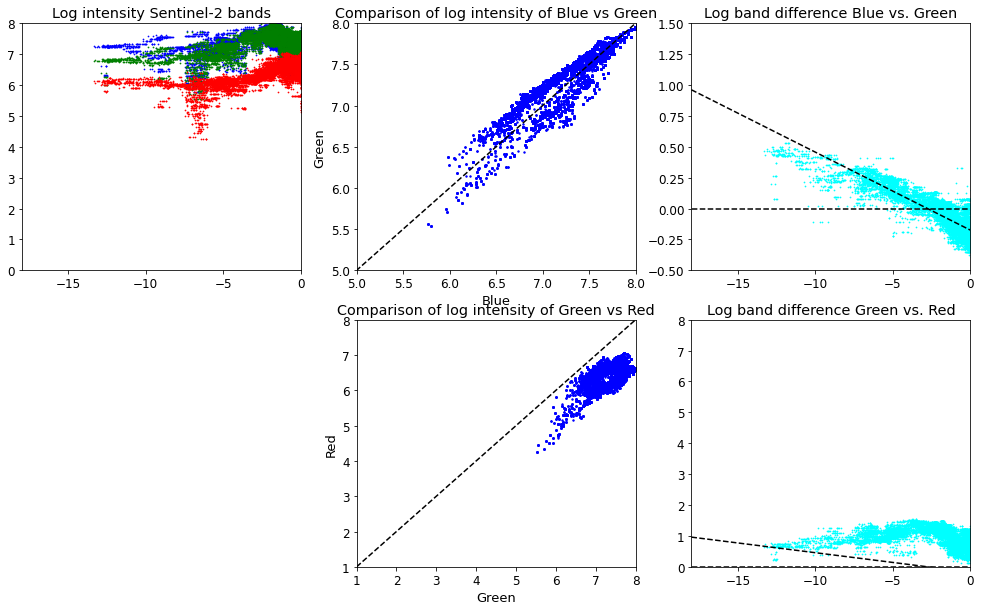

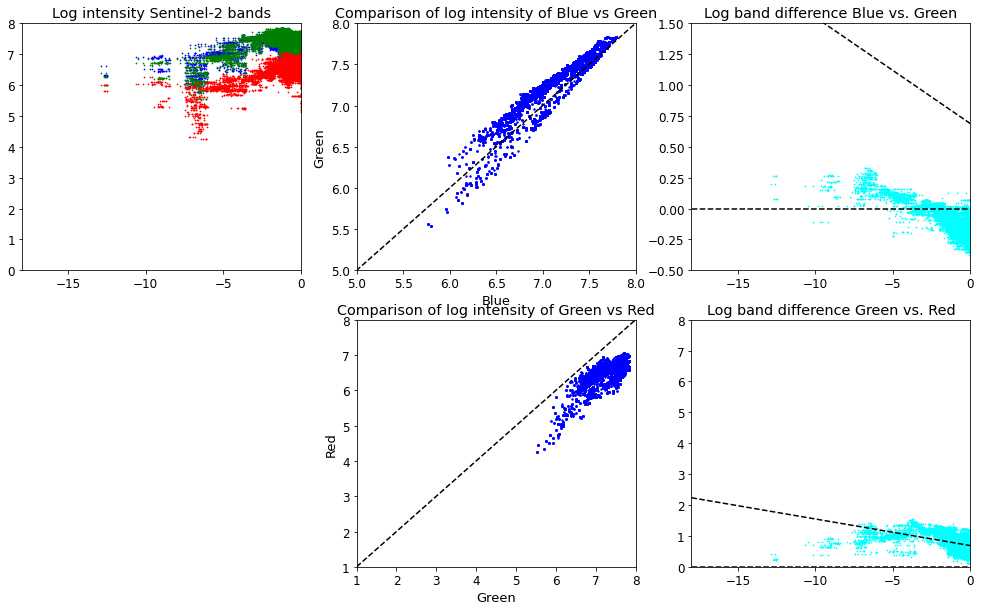

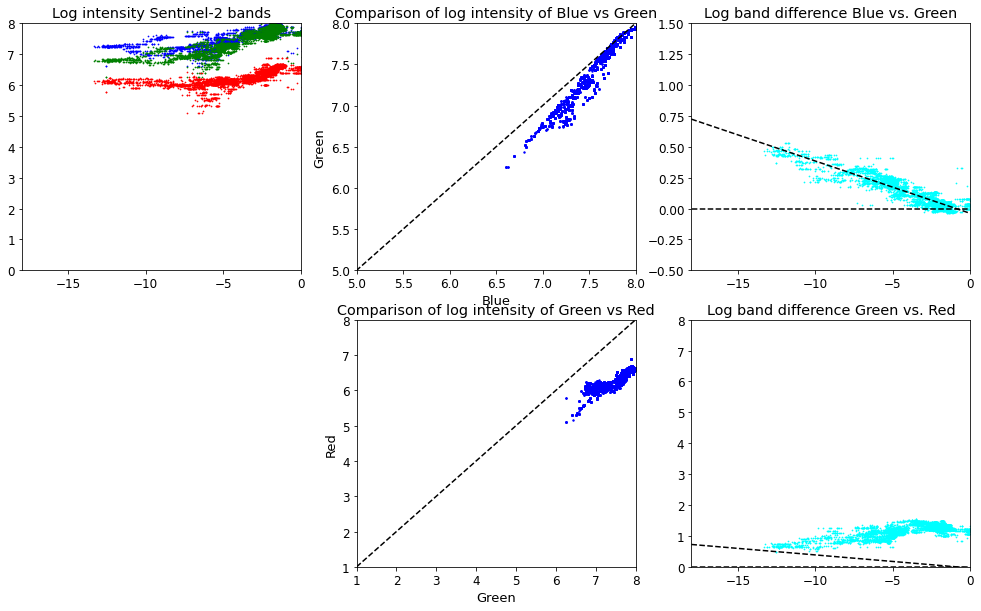

In [19]:
importlib.reload(reef_plots)

#histogram plots of raw data
#reef_plots.depth_histogram_plot(train_test_cleaned)
#reef_plots.depth_histogram_plot(train_test_use)

#depth vs log bands for all data
x = train_test_cleaned.loc[:,['Height']]
y = train_test_cleaned.loc[:,['diff_b2_b3']]
m, c = np.polyfit(np.ravel(x), np.ravel(y), 1) #m = slope, c=intercept
reef_plots.plot_sentinel_cal(train_test_cleaned, m, c)
print(m, c)

#separate pixels where Blue>Green from Green>Blue (unexpected)
slope = 1.3
intercept = -2.3
#slope = 1
#intercept = 0
train_test_use = train_test_cleaned.loc[(train_test_cleaned.log_b3 - slope*train_test_cleaned.log_b2 - intercept < 0)]
train_test_toss = train_test_cleaned.loc[(train_test_cleaned.log_b3 - slope*train_test_cleaned.log_b2 - intercept >= 0)]# & (train_test_cleaned.log_b4 > 2)]
#train_test_toss = train_test_cleaned.loc[(train_test_cleaned.log_b3 - slope*train_test_cleaned.log_b2 - intercept >= 0) & (train_test_cleaned.Height > -4)]

#depth vs log bands for points where Green>Blue
x = train_test_toss.loc[:,['Height']]
y = train_test_toss.loc[:,['diff_b3_b4']]
m, c = np.polyfit(np.ravel(x), np.ravel(y), 1) #m = slope, c=intercept
reef_plots.plot_sentinel_cal(train_test_toss, m, c)
print(m, c)

#depth vs log bands for points where Blue>Green
x = train_test_use.loc[:,['Height']]
y = train_test_use.loc[:,['diff_b2_b3']]
m, c = np.polyfit(np.ravel(x), np.ravel(y), 1) #m = slope, c=intercept
reef_plots.plot_sentinel_cal(train_test_use, m, c)
print(m, c)

In [20]:
#return preferred data
line = lambda x: (x-c) /m
out = train_test_cleaned[['x','y','b2','b3','diff_b2_b3','Height']]

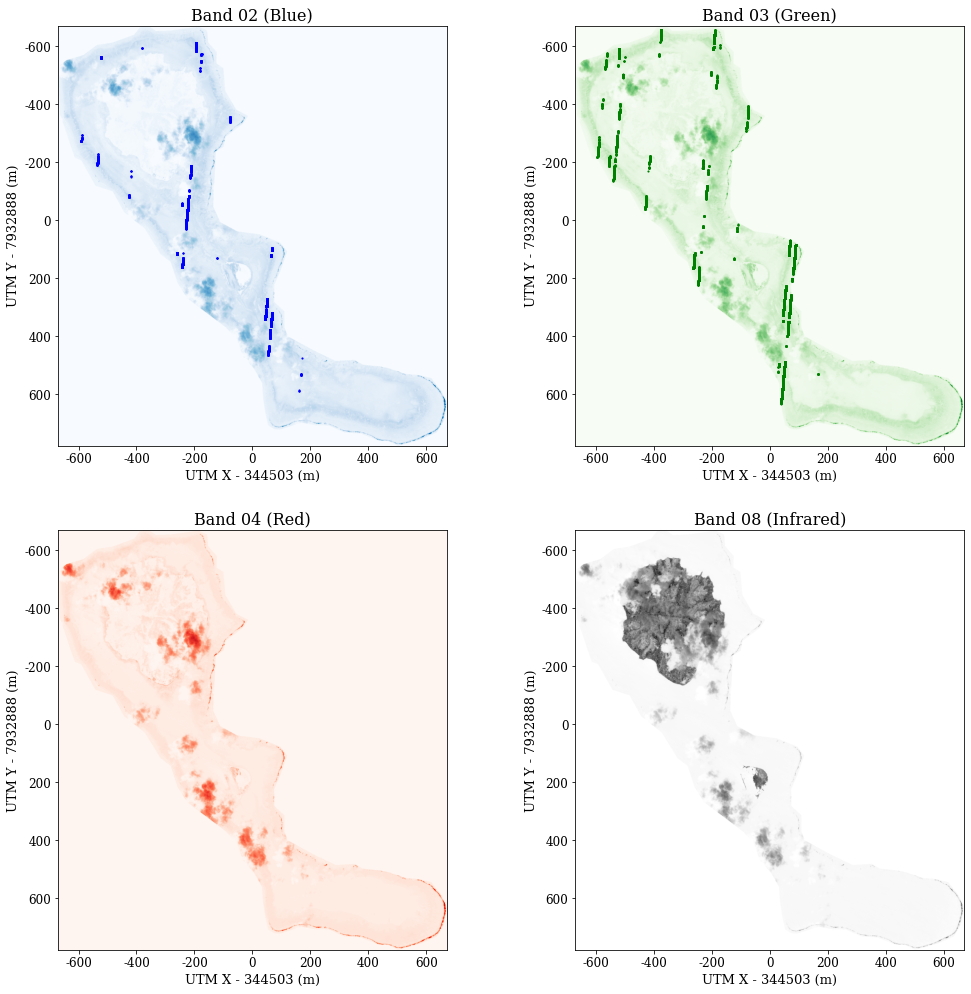

In [21]:
reef_plots.plot_sentinel_bands(imgs, meta, train_test_use, train_test_toss)

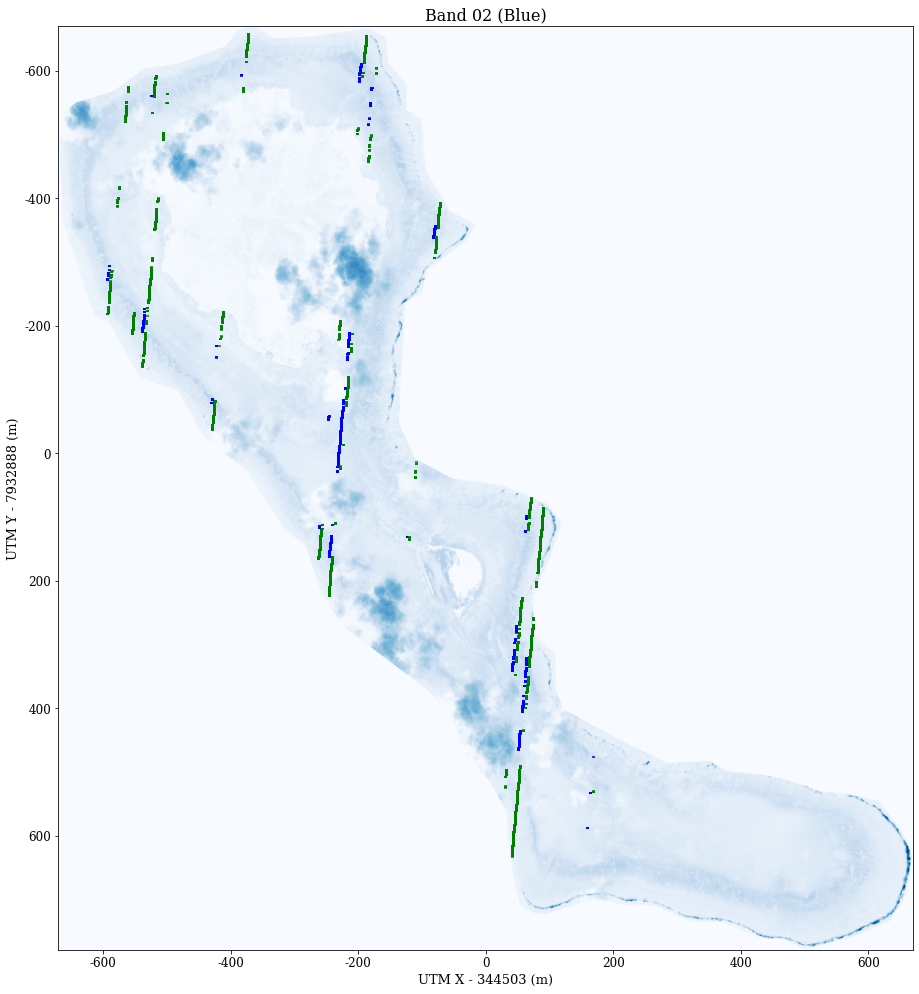

In [22]:
reef_plots.plot_sentinel_bands_closeup(imgs, meta, train_test_use, train_test_toss)

Continuation of Pixel_transformation.py/all_safe_files

In [23]:
#Do this for each Sentinel-2 image
#r = line
#m = metadata
#d = cleaned dataset
sample_median = np.median(train_test_cleaned['diff_b2_b3'])
sample_variance = np.var(train_test_cleaned['diff_b2_b3'])
medians.append(sample_median)
variances.append(sample_variance)

#checks if median and variances is between required threshold to be considered a valid image
#if np.abs(sample_median) < median_threshold and sample_variance < variance_threshold:

datum[safe_file] = (line, meta, out)
training_data_out_fn = '{reef_name}_training_data_{date}.csv'.\
    format(reef_name = reef_name, date = safe_file.get_date().strftime("%Y%m%d%H%M%S"))
print(training_data_out_fn)
train_test_cleaned.to_csv(os.path.join(training_data_path, training_data_out_fn))

nasau_training_data_20191018221110.csv


Pixel_transformation.py/predict_reef

In [24]:
# predict_reef(reg, sf,master_df):
# called as: preds,master_df = predict_reef(line, safe_file, master_df)
#
#    Predict the depth of the reef using colour pixel values
#    Params - 1. reg (lambda) - predict depth using pixel values
#             2. sf (Sentinel2_image) - Object representing sentinel image
#             3. master_df (DataFrame) - contains depth predictions from all sentinel images
#    Return - str - path of out file
#           - DataFrame - containing depth predictions from all sentinel images

#create lists to store required values
x, y, height, pix, log_pix = [],[],[],[],[]
meta = safe_file.get_meta()

#loads in the required images
b2_pix, b3_pix, _, b8_pix = meta['imgs']
print(b2_pix.shape, b3_pix.shape, b8_pix.shape)

#store the masking threshold
mask_thresh = meta['mask_thresh']
tide_level = safe_file.get_tide()
bbox_coords = safe_file.read_gjson()['geometry'][0].bounds
print(mask_thresh, tide_level, bbox_coords)

#loop through the image coordinates
for j in tqdm(range(len(b2_pix[0]))):
    for i in range(len(b2_pix[0][0])):
        b2, b3, b8 = b2_pix[0][j][i], b3_pix[0][j][i], b8_pix[0][j][i]
        if b2 and b3:
            
            #generate x,y coordinate for pixel
            x_coord = bbox_coords[0] + ((i)*meta['xdim']) + 5
            y_coord = bbox_coords[3] + ((j)*meta['ydim']) - 5
            p = Point((x_coord, y_coord))
            
            #get the normalised band values
            bp = meta['min_pix']
            delta = 0.0001
            band_2 = max(delta, b2 - bp['B02'])
            band_3 = max(delta, b3 - bp['B03'])
            band_8 = b8
            
            #store the normalised pixel value
            pix.append([band_2, band_3, band_8])
            
            #if the band 8 value is higher than the threshold we predict, use nan for the height, else the depth adjust with the tide
            if band_8 > mask_thresh:
                height.append(np.nan)
            else:
                x_feat = math.log(band_2) -  math.log(band_3)
                pred = (line(x_feat) - tide_level)
                if pred >= -30 and pred <= 10:
                    height.append(pred)
                else:
                    height.append(np.nan)

            x.append(x_coord)
            y.append(y_coord)

#create a dataframe with the output information and save that df as a csv
df = pd.DataFrame([x, y, height, pix, log_pix]).T
df.columns = ['x', 'y', 'Height', 'normalised_pixel', 'diff']

#add predictions to master_df
if 'x' not in master_df.columns:
    master_df['x'] = df.x
if 'y' not in master_df.columns:
    master_df['y'] = df.y
dt = safe_file.get_date()
master_df[str(dt.strftime("%Y/%m/%d"))] = df.Height

out_fn = '{reef_name}_out_{dt}.csv'.format(reef_name = safe_file.reef_name, dt = dt.strftime("%Y%m%d%H%M%S"))
out_fp = os.path.join(safe_file.depth_preds_path, out_fn)

df.to_csv(out_fp)

  1%|▏         | 20/1449 [00:00<00:07, 198.26it/s]

(1, 1449, 1340) (1, 1449, 1340) (1, 1449, 1340)
444.49221645663454 0.411 (337803.4093075963, 7925655.163631841, 351193.6527030583, 7940133.253426169)


100%|██████████| 1449/1449 [00:22<00:00, 64.81it/s] 


In [25]:
reef_plots.plot_reefs(out_fp, train_test_cleaned, safe_file, line)

In [26]:
# This is for when multiple Sentinel files are processed
#preds = master_df.drop(['x','y'], axis = 1)
#len_preds = len(preds.columns)
#master_df['median'] = preds.apply(lambda x: np.median(x.dropna()) if len(x.dropna()) > int(0.75*len_preds) else np.nan, axis = 1)
#master_df['mean'] = preds.apply(lambda x: np.mean(x.dropna()) if len(x.dropna()) > int(0.75*len_preds) else np.nan, axis = 1)
#preds['max'] = preds.apply(max, axis = 1)
#preds['min'] = preds.apply(min, axis = 1)
#master_df['range'] = preds['max'] - preds['min']
#median_df = master_df[['x','y','median']]

## Testing: Get tides

In [27]:
epoch = datetime.utcfromtimestamp(0)
dt = is2.get_date()
ut = (dt - epoch).total_seconds()
print(epoch)
print(dt)
print(dt - epoch)
print(ut)

bbox = is2.bbox_coordinates
print(bbox)

1970-01-01 00:00:00
2020-03-08 14:56:11
18329 days, 14:56:11
1583679371.0
(-178.53760600090027, -18.755206591925898, -178.4115636348724, -18.62375715561433)


In [28]:
#tide_level = tide.get_tide(is2.bbox_coordinates, is2.get_date())
min_longitude,min_latitude,max_longitude,max_latitude = is2.bbox_coordinates
lat = str((min_latitude+max_latitude)/2)
lon = str((min_longitude+max_longitude)/2)
stadist = 100
base_url = 'https://www.worldtides.info/api/v2?heights'

tide_datum = 'MTL'
query_string = '&lat={lat}&lon={lon}&start={ut}&datum={datum}&key={api_key}&station_distance={stadist}'\
    .format(lat = lat,lon = lon,ut = ut,datum = tide_datum,api_key = tide.get_API_key(),stadist=stadist)
print(query_string)

&lat=-18.689481873770113&lon=-178.47458481788635&start=1583679371.0&datum=MTL&key=fee8ff39-48eb-42a7-bcc5-3819fce3c1e4&station_distance=100


In [29]:
url = base_url + query_string
#hitting API and storing contents in json format
r = requests.get(url)
tide = json.loads(r.text)

In [30]:
print(tide['heights'][0:1])
print(tide['responseLat'])
print(tide['responseLon'])
print(tide['atlas'])
print(tide['responseLat'])
print(tide['responseLon'])
print(tide['responseDatum'])

[{'dt': 1583679371, 'date': '2020-03-08T14:56+0000', 'height': 0.003}]
-18.6667
-178.5
TPXO
-18.6667
-178.5
MTL
